In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time as time
import subprocess 

from SimulationControl import SimControl

ps = {"ImprovedSpatial": 3,
      "Small_world":0.01 ,
      "Scale_free": 1, 
      "SBlock": 1-0.01,
      "Regular": 0,}


SimCon = SimControl()

SimCon.params["Network_type"] = "SBlock"
SimCon.params["n"] = 100
SimCon.params["k"] = 9
SimCon.params["p"] = 0.25 #ps[SimCon.params["Network_type"]]


SimCon.params["Notebook"] = 2 #1 is to save the firing data, 2 is to save the network data and firing data, 0 is for simulating on cluster
SimCon.params["simtime"] = 1500
SimCon.params["h"] = 0.01

SimCon.params["StimSites"] = 0
SimCon.params["StimAmplitude"] = 1
SimCon.params["StimFrequency"] = 140

SimCon.Generate_Command()

'python Simulation.py 9 0.25 1500 2 1 0.02 testrun -1.0 26278342 -0.2 SBlock 3.0 0.02 0.25 0.25 20 100 0.01 2 0 1 140'

In [28]:
t0 = time.time()
p = subprocess.Popen(SimCon.Generate_Command(),stdout=subprocess.PIPE, stderr=subprocess.PIPE)
out, err = p.communicate()
print(out.decode('UTF-8'))
print(err.decode('UTF-8'))

t1 = time.time()

print(f"Time taken: {t1-t0:.2f}")


data = np.load(f"B:\SimOutput\\NotebookData.npy",allow_pickle=True).item()
netdat = np.load(f"B:\SimOutput\\NotebookNetworkData.npy",allow_pickle=True).item()

STN = data["STN"]
GPe = data["GPe"]
data_dict = data["data"]

STG_list = netdat["STG_list"]
GTS_list = netdat["GTS_list"]
GTG_list = netdat["GTG_list"]
graph_measures = netdat["graph_measures"]

#Make sure the correct data is being loaded 
for key in SimCon.params:
    if key not in ['weight', 'GSweight', 'GGweight']: # these params dont count
        assert SimCon.params[key] == data_dict[key]

dt = SimCon.params["h"]
simtime = SimCon.params["simtime"]

def get_spike_trains(pop):
    main_lis = []
    for sp in pop.spiketrains:
        s_lis = [ float(i) for i in sp] 
        main_lis.append(np.array(s_lis))

    return main_lis

low_cutoff = int(500/dt) #number of segments corresponding to first 500ms

SLFP = np.array(STN.filter(name='soma(0.5).v')[0]).mean(axis=1)#(axis=1)
GLFP = np.array(GPe.filter(name='soma(0.5).v')[0]).mean(axis=1)


packed_dat = [{"SLFP": SLFP,"GLFP": GLFP,
               "STrain":get_spike_trains(STN),
               "GTrain":get_spike_trains(GPe),
               "Sync":np.sqrt(data_dict['STN synchrony']*data_dict['GPe synchrony']) ,
              "SMean":data_dict["SMean"],
               "GMean":data_dict["GMean"],
              }]
#loc = 'dataOct21\\'
netname = data_dict['Network_type']
#name = f'S_{netname}_{n}_{data_dict["k"]}_{data_dict["p"]:5f}_{data_dict["recip"]:.5f}.npy'
#np.save(loc+name,packed_dat)
recovered_dat = packed_dat[0] #np.load(loc+name,allow_pickle=True)[0]

print('Lambda2: ', sorted(graph_measures['eigs'])[1])

Subtle Desynchronisation

c:\users\catha\desktop\shortcuts\python\pynn-0.9.5\pyNN\neuron\recording.py:115: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  signals = numpy.vstack((id._cell.traces[variable] for id in ids)).T

Time taken: 60.13
Lambda2:  0.5059510514954902


Text(0.72, 0.95, 'Mean $\\chi$: 0.347\nSTN FR:  33.74 \nGPe FR:  12.96 ')

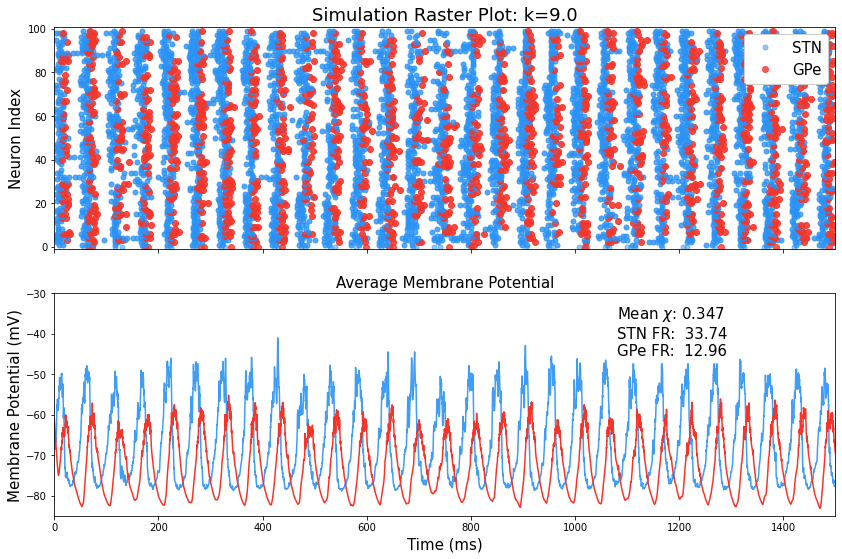

In [29]:
cols = '#2A92F5'
colg = '#F5352A'

k = data_dict["k"]
netlab = {'Regular':'k-Regular',  'Small_world': 'Small World','Spatial':'Nearest Neighbour',
          'Scale_free': 'Preferential Attachment','SBlock': 'Stochastic Block'}

SLFP = recovered_dat["SLFP"]
GLFP = recovered_dat["GLFP"]

STrain = recovered_dat["STrain"]
GTrain = recovered_dat["GTrain"]

sync = float(recovered_dat["Sync"])
textstr = r'Mean $\chi$: '+ f'{sync:>3.3f}' + f"\nSTN FR: {data_dict['SMean']:>6.2f} \nGPe FR: {data_dict['GMean']:>6.2f} " 

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=1,edgecolor='white')

# place a text box in upper left in axes coords

infigfontsize = 15
titlefontsize = 18

ilim = 100

x_axis = np.linspace(0,simtime,len(GLFP))

fig,ax = plt.subplots(2,1,figsize=[14,9],sharex=True)
#fig.suptitle(params["Network_type"])

for i, train in enumerate(zip(STrain,GTrain)):
    train1 = train[0]
    train2 = train[1]
    if i>ilim:
        break
    if i==0:
        ax[0].plot(train1, i*np.ones(len(train1)), 'o', color = cols,markersize=5, alpha=0.5, label='STN')
        ax[0].plot(train2, i*np.ones(len(train2)), 'o', color = colg,markersize=6, alpha=0.8, label='GPe')
    else:
        ax[0].plot(train1, i*np.ones(len(train1)), 'o', color = cols,markersize=5, alpha=0.8)
        ax[0].plot(train2, i*np.ones(len(train2)), 'o', color = colg,markersize=6, alpha=0.9)


#f'{netlab[data_dict["Network_type"]]} Network'
ax[0].set_title(f'Simulation Raster Plot: k={k}',fontsize=titlefontsize)
ax[0].set_ylabel("Neuron Index",fontsize=infigfontsize)
ax[0].set_xlim(0,1500)
ax[0].set_ylim(-1,ilim+1)
ax[0].legend(fontsize=infigfontsize,loc='upper right',framealpha=1)
#ax[0].legend(fontsize=16,framealpha=1,shadow = True,borderpad=0.8,loc='upper right')

ax[1].plot(x_axis, SLFP, label = 'STN',color = cols, alpha=0.9)
ax[1].plot(x_axis, GLFP, label = 'GPe',color = colg, alpha=1)
ax[1].set_title('Average Membrane Potential',fontsize=infigfontsize)
ax[1].set_ylabel("Membrane Potential (mV)",fontsize=infigfontsize)
ax[1].set_xlabel("Time (ms)",fontsize=infigfontsize)
ax[1].set(ylim=[-85,-30,])
ax[1].text(0.72, 0.95, textstr, transform=ax[1].transAxes, color='k', fontsize=infigfontsize, verticalalignment='top', bbox=props)


In [4]:
#np.save("AmalgDataApril\\"+f"{netname}_{int(k)}.npy",recovered_dat)  
# dat2={}

# for S in ["Spatial","Small_world","Scale_free", "SBlock","Regular"]:
#     for K in [5,30]:
#         dat2[(S,K)] = np.load("NewAmalgData\\"+f"{S}_{int(K)}.npy",allow_pickle=True).item(0)

        

In [11]:
data_dict['SFRvar']/data_dict['SMean']

0.23129639486314335

In [12]:
data_dict['GFRvar']/data_dict['GMean']

0.4413305044636219